# Testing Higher-Order Statistics in TXPipe
## The Fast Projected Bispectrum

This notebook shows how to test a stage computing a higher-order statistic in a notebook. Our production pipelines are all written in terms of pipeline files, such as those in the "examples" directory, but for testing we can run stages through notebooks.

The stage used as an example here is `HOSFSB`, which is a fast filtered bi-spectrum calculation, developed by Léa Harscouet and described in https://arxiv.org/abs/2409.07980

The code can be found in `txpipe/extenions/hos/fsb.py`



In [1]:
import sys
sys.path.append("..")
sys.path.append("../submodules/pyfsb")

import sacc
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import txpipe
import pyccl as ccl
import scipy.stats as st
import numpy as np

# Input mock data

First we generate mock input data for the FSB to run on. We generate C_ells from a Vanilla LCDM cosmology and then use healpy to make a map

In [2]:

nside = 256

def generate_cls(nside):
    # multipole range
    ells = np.arange(3*nside)

    # a survey redshift distribution
    z = np.linspace(0.005, 1, 100)
    dndz = st.lognorm.pdf(z, 0.4, loc=0.35, scale=.2)

    # generate cosmology
    cosmo = ccl.CosmologyVanillaLCDM()
    bias = 2.0
    bz = np.ones_like(z)*bias
    tracer = ccl.NumberCountsTracer(cosmo, has_rsd=False, dndz=(z, dndz), bias=(z, bz))

    # compute angular power spectrum
    c_ell = ccl.angular_cl(cosmo, tracer, tracer, ells)

    return z, dndz, c_ell


def generate_map(cl, nside):

    """
    This function generates a non-gaussian map from a given power 
    spectrum using Lagrangian Perturbation Theory on the 2D sphere
    (Alonso et al. 2015: https://arxiv.org/abs/1512.03402).
    """

    alm = hp.synalm(cl, lmax=3*nside-1)
    
    ls = np.arange(3*nside)
    fl = np.sqrt((ls+2)*(ls+1)*ls*(ls-1))/(ls*(ls+1))
    fl[:2] = 0
    
    elm = hp.almxfl(alm, fl)
    delta = hp.alm2map(alm, nside)
    
    Q, U = hp.alm2map_spin([elm, 0*elm], nside=nside, spin=2, lmax=3*nside-1)

    H11 = 1+0.5*(delta+Q)
    H22 = 1+0.5*(delta-Q)
    H12 = 0.5*U

    return H11*H22-H12**2-1

z, dndz, some_standard_cls = generate_cls(nside)
density_map = generate_map(some_standard_cls, nside)
mask = np.ones_like(density_map)


/var/folders/81/dnhq_82s0w380_dw8p4p5wn80000gn/T/ipykernel_86191/2765175375.py:34: RuntimeWarning: invalid value encountered in divide
  fl = np.sqrt((ls+2)*(ls+1)*ls*(ls-1))/(ls*(ls+1))


# Saving in TXPipe format

TXPipe uses its own format for saving map and mask information. In a real pipeline these files will be generated internally by the pipeline from shear catalogs, but here we make mock versions.

In [3]:
# Save the maps. In this case 

metadata = {"nside": nside, "pixelization": "healpix"}

# Save the overdensity map as a TXPipe file
with txpipe.data_types.MapsFile("maps.hdf5", "w") as f:
    f.write_map("delta_0", np.arange(len(density_map)), density_map, metadata)
    f.file["maps"].attrs["nbin_lens"] = 1

# Save the mask as a TXPipe file
with txpipe.data_types.MapsFile("mask.hdf5", "w") as f:
    f.write_map("mask", np.arange(len(mask)), mask, metadata)


# Setting up precursor metadata

In production we would run a full precursor pipeline to obtain n(z) information and metadata as well as input maps for our HOS stage.  You can see an example of doing that by running (after downloading the mock data - see the README):

```bash
ceci examples/metadetect/pipeline.yml
```

But here we will save our mock n(z) data and some minimal tracer information. These are not actually used in measuring our higher order statistic, but are copied into the output data.

TXPipe uses the QP format for n(z) data.




In [4]:
import qp

# Make the n(z) into a 2D array which QP wants, and save it.
# The code is expecting to receive both the tomographic distributions
# and an overall distribution, so we need to duplicate the dndz array.
q = qp.Ensemble(qp.interp, data={"xvals":z, "yvals":np.array([dndz, dndz])})
with txpipe.data_types.QPNOfZFile('n_of_z.hdf5', 'w') as f:
    f.write_ensemble(q)

# Save a minimal metadata file, with just the galaxy density in.
with txpipe.data_types.HDFFile("metadata.hdf5", "w") as f:
    g = f.file.create_group("tracers")
    g.create_dataset("lens_density", data=[0.1])

    # This source sample info is not actually used in this notebook,
    # but if you were running your statistics on convergence or shear maps
    # instead of a density map then you would need to include them.
    g.create_dataset("source_density", data=[1.0, 2.0, 3.0])
    g.create_dataset("n_eff", data=[1.0, 2.0, 3.0])



# Running the stage

We now run the pipeline stage.  We could do this from the command line, or from within a notebook like this.  In general it's useful to construct a proper pipeline file once you've finished testing things.

In [5]:
from txpipe import HOSFSB

args = {
    # Input files that we made above.
    "density_maps": "maps.hdf5",
    "mask": "mask.hdf5",
    "lens_photoz_stack": "n_of_z.hdf5",
    "tracer_metadata": "metadata.hdf5",

    # The configuration file is searched for any configuration options
    # not specified here. We don't actually need it here, so we just
    # use an example from another pipeline
    "config": "../examples/metadetect/config.yml",

    # The output file where the results will be saved.
    "filtered_squared_bispectrum": "fsb.sacc",
}

# Make, run, and finalize the stage.
stage = HOSFSB(args)
stage.run()
stage.finalize()

Loaded 1 overdensity maps
computed cls_11_binned for the 1st (and hopefully only) time
computed gauss_cov for the 1st (and hopefully only) time
computed cls_12_unbinned for the 1st (and hopefully only) time
computed cls_22_unbinned for the 1st (and hopefully only) time
computed fsb_unbinned_pure for the 1st (and hopefully only) time
computed f1s for the 1st (and hopefully only) time
computed fsb_unbinned for the 1st (and hopefully only) time
computed cls_1sq1sq_unbinned for the 1st (and hopefully only) time
computed cls_11_unbinned for the 1st (and hopefully only) time
computed fsb_binned for the 1st (and hopefully only) time


/Users/jzuntz/src/lsst/TXPipe/conda/lib/python3.10/site-packages/sacc/data_types.py:304: UserWarning: Unknown data_type value galaxy_density_filteredSquareBispectrum. If possible use a pre-defined type, or add to the list.
  warnings.warn(f"Unknown data_type value {data_type}. "


# Reading and plotting the results

/Users/jzuntz/src/lsst/TXPipe/conda/lib/python3.10/site-packages/sacc/data_types.py:304: UserWarning: Unknown data_type value galaxy_density_filteredSquareBispectrum. If possible use a pre-defined type, or add to the list.
  warnings.warn(f"Unknown data_type value {data_type}. "


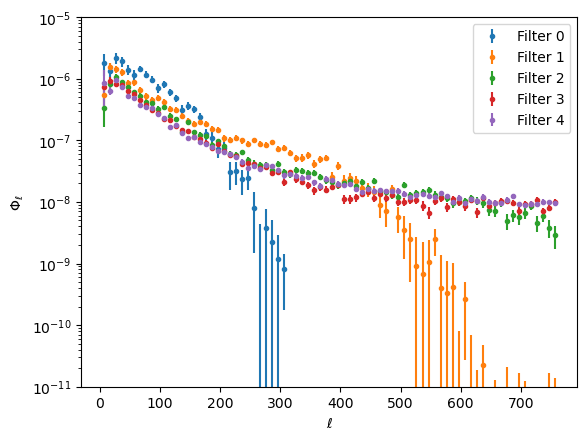

In [6]:
# Load the sacc file
s = sacc.Sacc.load_fits("fsb.sacc")

# SACC data consists of a sequence of data points with a set of tags attached
# as metadata, and tracer information for them.
for f in range(5):

    # For a 3pt function the measurements have three tracers, but here we have only
    # done auto-correlations, and only have one tomographic bin, so this is the only
    # set of traers
    tracers = ('lens_0', 'lens_0', 'lens_0')

    # We chose this data type name (following the sacc scheme) in the stage code.
    data_type = "galaxy_density_filteredSquareBispectrum"

    # The tag stores the ell information for the points. We can use `get_tag` to 
    # get the ell values for a set of data points. We request a specific data type
    # for the FSB measurements, and specialise to one set of tracers and one filter
    ell = s.get_tag("ell", data_type, tracers, filter=f)
    index = s.indices(data_type, tracers, filter=f)
    cov = s.covariance.get_block(index)
    sigma = np.sqrt(np.diag(cov))


    # Similarly we get the meaasured value of the statistic with `get_mean`
    y = s.get_mean(data_type, tracers, filter=f)

    # and finally plot
    plt.errorbar(ell, y, sigma, label=f"Filter {f}", fmt='.')
    plt.yscale("log")

plt.legend()
plt.xlabel(r"$\ell$")
plt.ylabel(r"$\Phi_\ell$")
plt.ylim(1e-11, 1e-5);

# Plotting the covariance

The SACC file can also (optionally) store the covariance of measurements, if available.

In the FSB case these are analytic and computed along with the statistic itself.

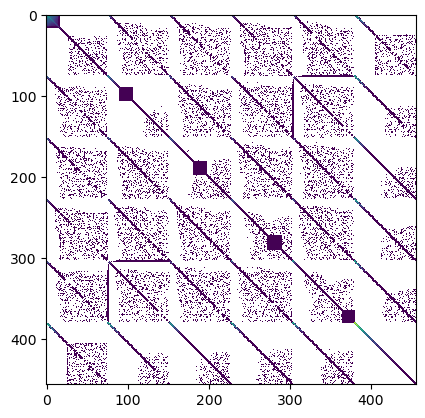

In [7]:
c = s.covariance.dense
plt.imshow(c, norm='log');

# Cutting our SACC file

The FSB calculation also saves the C_ell calculation as a by-product of the measurement, and the covariance above includes that data.  Here we show how to cut down to a specific data type in a sacc file.

The selection tools affect both the data and covariance, so we will illustrate it here by zooming in on the covariance block just for the 3pt information.

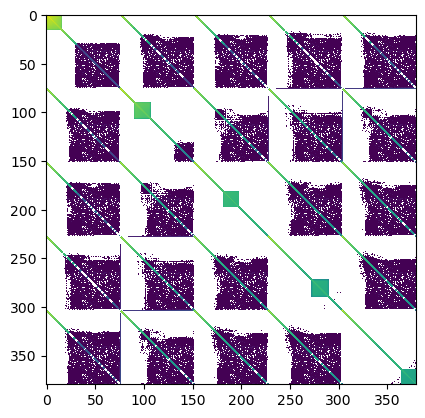

In [8]:

# The selection tools operate in-place, throwing out data inside the sacc object.
# So first we make a copy of it to avoid affecting the original object.
s2 = s.copy()

# Select only one data type, for our HOS.  We could also use remove_selection, and we coult
# give either method more options to cut down to specific tomographic bin combinations
# or ell values.
s2.keep_selection("galaxy_density_filteredSquareBispectrum")
plt.imshow(s2.covariance.dense, norm='log');


